In [6]:
from bs4 import BeautifulSoup
import os

### 1. Getting the word list

In [7]:
# get the list of files in data/brown-UKR directory
files = os.listdir('../data/brown-UKR')

In [8]:
lemmas = []

for file in files:
    with open('../data/brown-UKR/' + file, 'r') as f:
        soup = BeautifulSoup(f.read(), features="xml")
    
    tokens = soup.find_all('token')
    non_punct = [token for token in tokens if token['tags'] != 'punct']

    lemmas += [token['lemma'].lower() for token in non_punct if token['lemma'].isalpha()]

In [9]:
# dictionary with frequencies for eahc unique lemma
lemma_freq = {}

for lemma in lemmas:
    if lemma in lemma_freq:
        lemma_freq[lemma] += 1
    else:
        lemma_freq[lemma] = 1

In [10]:
unique_f = list(lemma_freq.keys())
# remove lemmas that occur only once
for lemma in unique_f:
    if lemma_freq[lemma] == 1:
        lemma_freq.pop(lemma)

unique_f = list(lemma_freq.keys())

In [11]:
len(unique_f)

20565

In [12]:
unique_f

['факт',
 'укладання',
 'договір',
 'страхування',
 'страховий',
 'свідоцтво',
 'встановлений',
 'зразок',
 'страхові',
 'платіж',
 'визначатися',
 'за',
 'розмір',
 'сума',
 'строк',
 'та',
 'ступінь',
 'ризик',
 'з',
 'одночасний',
 'використання',
 'граничний',
 'тарифний',
 'ставка',
 'у',
 'раз',
 'настання',
 'випадок',
 'страхувальник',
 'повинний',
 'вжити',
 'захід',
 'щодо',
 'запобігання',
 'зменшення',
 'збиток',
 'упродовж',
 'доба',
 'заявити',
 'в',
 'орган',
 'міліція',
 'про',
 'знищення',
 'будівля',
 'унаслідок',
 'навмисний',
 'неправомірний',
 'дія',
 'третій',
 'особа',
 'пожежа',
 'пожежний',
 'нагляд',
 'добовий',
 'письмово',
 'страховик',
 'компанія',
 'і',
 'заява',
 'докладно',
 'вказати',
 'коли',
 'який',
 'обставина',
 'знищити',
 'пошкодити',
 'компетентний',
 'це',
 'зберегти',
 'до',
 'прибуття',
 'на',
 'місце',
 'пошкоджений',
 'такий',
 'стан',
 'вони',
 'мати',
 'після',
 'припинення',
 'вплив',
 'подія',
 'прийняти',
 'зареєструвати',
 'або',
 'уш

### 2. LSTM

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import (Dataset,
                              DataLoader, 
                              TensorDataset)

import matplotlib.pyplot as plt
import numpy as np

In [14]:
BS = 100

In [15]:
def generate_batch(batch):
    tensor = batch[0][0]
    batch_size = len(batch)
    max_length = max([len(entry[0]) for entry in batch]) - 1  # Does not need to predict SOS
    x = tensor.new_zeros(batch_size, max_length)
    y = tensor.new_zeros(batch_size, max_length)
    for i, item in enumerate(batch):
        sentence = item[0]
        sent_len = len(sentence) - 1  # Does not need to predict SOS
        # sent_len = len(sentence)
        x[i, :sent_len] = sentence[:-1]
        y[i, :sent_len] = sentence[1:]
    return x, y

In [16]:
data = [['<BOS>'] + list(word) + ['<EOS>'] for word in unique_f]

In [17]:
# list of unique characters from data
vocab = ['<PAD>'] + sorted(list(set([char for word in data for char in word])))

In [18]:
char_to_idx = {char:idx for idx, char in enumerate(vocab)}
idx_to_char = {idx:char for idx, char in enumerate(vocab)}


In [19]:
# get index of padding symbol
char_to_idx['<PAD>']

0

In [20]:
# data train and test split
train_data = data[:int(len(data) * 0.8)]
test_data = data[int(len(data) * 0.8):]

In [21]:
padded_train = torch.nn.utils.rnn.pad_sequence([torch.tensor([char_to_idx[x] for x in y]) 
                                                for y in train_data],
                                               batch_first=True)

padded_test = torch.nn.utils.rnn.pad_sequence([torch.tensor([char_to_idx[x] for x in y])
                                                  for y in test_data],      
                                                batch_first=True)

In [22]:
dataset_train = TensorDataset(padded_train)
dataloader_train = DataLoader(dataset_train, batch_size=BS, shuffle=True, collate_fn=generate_batch)

In [23]:
dataset_test = TensorDataset(padded_test)
dataloader_test = DataLoader(dataset_test, batch_size=BS, shuffle=True, collate_fn=generate_batch)

In [24]:
class LstmLM(nn.Module):
    def __init__(self, vocab_size, hidden_size, emb_dim=8, n_layers=1, dropout_p=0.2):
        '''
        This model is based on https://github.com/rycolab/homophony-as-renyi-entropy 
        implementation. It improves on it by adding the tracing of padding inside the forward
        loop, so it can be trained on batches. 
        '''
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        super(LstmLM, self).__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings= vocab_size,
            embedding_dim = emb_dim,
            padding_idx=0)
        
        self.lstm = nn.LSTM(
            input_size =emb_dim,
            hidden_size=hidden_size,
            num_layers =n_layers,
            dropout=(dropout_p if n_layers > 1 else 0),
            batch_first=True)
        
        self.dropout = nn.Dropout(dropout_p)
        self.linear = nn.Linear(hidden_size, 
                                emb_dim)
        self.out = nn.Linear(emb_dim, 
                             vocab_size)
    
    def forward(self, x):
        '''
        Theoreticaly, this forward call should ignore padding
        '''
        x_emb = self.embedding(x)

        x_emb_p = nn.utils.rnn.pack_padded_sequence(x_emb,
            x.detach().count_nonzero(dim=1).numpy(), 
            batch_first=True, 
            enforce_sorted=False)

        c_t, _ = self.lstm(x_emb_p)

        c_t_p = nn.utils.rnn.pad_packed_sequence(c_t, batch_first=True, padding_value=0, total_length=x.shape[1])[0]

        c_t_p = self.dropout(c_t_p).contiguous()

        hidden = F.relu(self.linear(c_t_p))
        logits = self.out(hidden)
        return logits

    def forward_(self, x, prev_state):
        '''
        Forwarding one example letter by letter for generation
        '''
        x_emb = self.embedding(x)
        x_emb_p = nn.utils.rnn.pack_padded_sequence(x_emb,
                                                    x.detach().count_nonzero(dim=1).numpy(), 
                                                    batch_first=True, 
                                                    enforce_sorted=False)

        c_t, context = self.lstm(x_emb_p, prev_state)
        c_t_p = nn.utils.rnn.pad_packed_sequence(c_t, 
                                                 batch_first=True, 
                                                 padding_value=0, 
                                                 total_length=x.shape[1])[0]
        c_t_p = self.dropout(c_t_p).contiguous()
        hidden = F.relu(self.linear(c_t_p))
        logits = self.out(hidden)
        return logits, context
        
    def init_state(self, b_size):
        return (torch.zeros(self.n_layers, b_size, self.hidden_size),
                torch.zeros(self.n_layers, b_size, self.hidden_size))

In [25]:
def train(model, data_train, data_eval, n_epochs, criterion, optimizer):
    loss_tr = []
    loss_ev = []
    
    for epoch in range(n_epochs):
        
        total_train_loss = 0
        model.train()
        
        for x, y in data_train:
            optimizer.zero_grad()
            
            out = model(x)
            
            loss = criterion(out.transpose(1, 2), y)
            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        avg_train_loss = total_train_loss / (len(data_train))
        loss_tr.append(avg_train_loss)
        
        total_eval_loss = 0
        
        for x, y in data_eval:
            
            with torch.no_grad():
                out = model(x)
                loss = criterion(out.transpose(1,2), y)
                total_eval_loss += loss.item()
        
        avg_eval_loss = total_eval_loss / (len(data_eval))
        loss_ev.append(avg_eval_loss)
        
        print(f'epoch: {epoch+1}/{n_epochs}, train loss: {avg_train_loss}, eval loss: {avg_eval_loss}')

    return loss_tr, loss_ev

In [26]:
model = LstmLM(len(char_to_idx), 64, 256, n_layers=2, dropout_p=0.33)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
loss_tr, loss_ev = train(model, dataloader_train, dataloader_test, 20, criterion, optimizer)

epoch: 1/20, train loss: 2.1304217121817848, eval loss: 0.9970149752639589
epoch: 2/20, train loss: 0.9678372953877304, eval loss: 0.9095288756347838
epoch: 3/20, train loss: 0.9149423570343942, eval loss: 0.8834058472088405
epoch: 4/20, train loss: 0.8902414300224998, eval loss: 0.8660826441787538
epoch: 5/20, train loss: 0.8750569094311107, eval loss: 0.8552072658425286
epoch: 6/20, train loss: 0.8631523265983119, eval loss: 0.851289682445072
epoch: 7/20, train loss: 0.853163307724577, eval loss: 0.8406740185760316
epoch: 8/20, train loss: 0.8453309326460867, eval loss: 0.8366212717124394
epoch: 9/20, train loss: 0.8379626588387923, eval loss: 0.8277642769472939
epoch: 10/20, train loss: 0.8327051971897934, eval loss: 0.8279510708082289
epoch: 11/20, train loss: 0.8269198843927095, eval loss: 0.8257917364438375
epoch: 12/20, train loss: 0.8218356706879356, eval loss: 0.820325554836364
epoch: 13/20, train loss: 0.8181127335086014, eval loss: 0.8165615385486966
epoch: 14/20, train loss

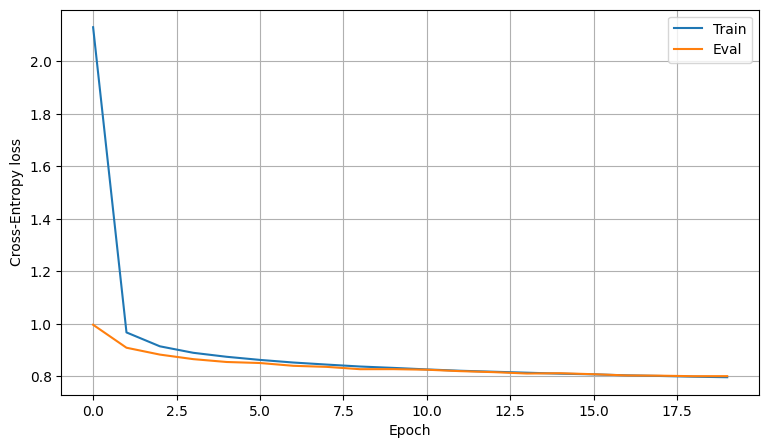

In [28]:
plt.figure(figsize=(9, 5))
plt.plot(loss_tr, label="Train")
plt.plot(loss_ev, label="Eval")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy loss")
plt.grid()

In [29]:
def extract_probs(model, x, y):
    with torch.no_grad():
        out = model(x)
        p = F.softmax(out.squeeze(), dim=1)
        compr = p * F.one_hot(y, num_classes=len(idx_to_char))
        sum = compr.sum(dim=2)
        sum[sum == 0] = 1

        x_ = x.detach().clone()
        x_[x_ != 0] = 1

        sum_ = x_ * sum
        sum_[sum_ == 0] = 1
        
        return  torch.prod(sum_, 1)

In [30]:
def eval_(model, data):
    
    list_of_mults = []
    shannon = []
    
    for x, y in data:
        probs = extract_probs(model, x, y)
        shannon.append(- (torch.log(probs) / np.log(2)))
        list_of_mults.append(-torch.log(probs))

    # print(torch.cat(list_of_mults, dim=0).shape)
        
    return f'Sum of prob: {torch.sum(torch.cat(list_of_mults, dim=0))} Avg Shannon: {torch.mean(torch.cat(shannon, dim=0))} Avg Prob: {torch.mean(torch.cat(list_of_mults, dim=0))}'

In [31]:
eval_(model, dataloader_train)

'Sum of prob: 224628.34375 Avg Shannon: 19.697919845581055 Avg Prob: 13.653558731079102'

In [32]:
eval_(model, dataloader_test)

'Sum of prob: 65999.5625 Avg Shannon: 23.150314331054688 Avg Prob: 16.04657554626465'

In [33]:
import math

def calculate_surprisal(model, word, char_to_idx, idx_to_char):
    # only if word isalpha
    if not word.isalpha():
        return None
    else:
        # if word only contains chars from the vocabulary
        if set(word).issubset(set(char_to_idx.keys())):
            word = word.replace(" ", "")
            model.eval()  # Set model to evaluation mode

            # Convert word to character indices
            word_indices = [char_to_idx[char] for char in word]
            word_tensor = torch.LongTensor(word_indices).unsqueeze(0)

            # Initialize hidden state
            hidden = model.init_state(1)  # Assuming batch size of 1

            # Forward pass through the model
            with torch.no_grad():
                logits, _ = model.forward_(word_tensor, hidden)
                probabilities = torch.softmax(logits.squeeze(0), dim=1)

            # Calculate surprisal of the word
            word_surprisal = 0.0
            for i, char in enumerate(word):
                char_idx = char_to_idx[char]
                char_prob = probabilities[i, char_idx]
                char_surprisal = -math.log2(char_prob.item())
                word_surprisal += char_surprisal

            return word_surprisal

In [34]:
calculate_surprisal(model, 'тапок', char_to_idx, idx_to_char)

45.18626546247861

### 2. Slovotvir supripsal

In [35]:
import pandas as pd

In [36]:
data = pd.read_csv('../data/data_preprocessing.csv')

In [37]:
# calculate surprisal for each translation_body
data['surprisal'] = data['translation_body'].apply(lambda x: calculate_surprisal(model, x, char_to_idx, idx_to_char))

In [38]:
# data withoun nan in surprisal
data = data[~data['surprisal'].isna()]

In [39]:
data

,word_id,word_body,translation_id,translation_body,rating,translation_created_at,translations_count,rating_n,translation_length,translation_age,n_words_word,n_words_translation,surprisal
0,1,мобільна аплікація,1.0,додаток,13,2014-04-29 15:21:20.626389,6,0.502079,7,3330,2,1,59.320144
1,1,мобільна аплікація,2.0,застосунок,22,2014-04-29 15:21:25.214140,6,1.529059,10,3330,2,1,85.227186
2,1,мобільна аплікація,7234.0,застос,2,2015-12-07 19:14:58.398291,6,-0.753119,6,2743,2,1,52.783724
3,1,мобільна аплікація,12243.0,аплікація,2,2017-06-03 00:05:56.275909,6,-0.753119,9,2200,2,1,111.414806
4,1,мобільна аплікація,46965.0,користанок,4,2021-10-28 20:32:30.697158,6,-0.524901,10,591,2,1,97.947286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33562,9875,делегат,61346.0,представник,1,2023-05-29 14:16:29.230315,3,-0.577350,11,13,1,1,131.124017
33563,9875,делегат,61348.0,заступник,1,2023-05-29 16:26:32.095239,3,-0.577350,9,13,1,1,105.397311
33564,9884,жижа,61432.0,жижа,1,2023-06-02 10:42:01.088799,6,-1.000000,4,10,1,1,53.671499
33565,9884,жижа,61434.0,рідота,2,2023-06-02 14:43:31.332028,6,0.000000,6,9,1,1,54.366188
